In [ ]:
import pandas as pd
import io
df = pd.read_csv('C:/Users/Tamara/Downloads/FinalData.csv')
print(df)

       Day        Date  Price        Exp
0        1  22/08/2000  32.05  32.050000
1        2  23/08/2000  31.63  32.029000
2        3  24/08/2000  32.05  32.030050
3        4  27/08/2000  32.87  32.072047
4        5  28/08/2000  32.72  32.104445
...    ...         ...    ...        ...
5574  5575  10/11/2022  86.47  87.638763
5575  5576  11/11/2022  88.96  87.704824
5576  5577  14/11/2022  85.87  87.613083
5577  5578  15/11/2022  86.92  87.578429
5578  5579  16/11/2022  85.59  87.479008

[5579 rows x 4 columns]


In [ ]:
print("This is the row number of the dataset:",len(df))
print(df.describe())

This is the row number of the dataset: 5579
               Day        Price          Exp
count  5579.000000  5579.000000  5579.000000
mean   2790.000000    63.572345    63.383574
std    1610.662907    25.846412    25.416994
min       1.000000    10.010000    19.748499
25%    1395.500000    43.880000    44.888399
50%    2790.000000    60.660000    60.466052
75%    4184.500000    84.865000    85.966306
max    5579.000000   145.290000   134.713344


In [ ]:
df['Price'] = df['Price'].astype(float)

In [ ]:
df.describe()

,Day,Price,Exp
count,5579.000000,5579.000000,5579.000000
mean,2790.000000,63.572345,63.383574
std,1610.662907,25.846412,25.416994
min,1.000000,10.010000,19.748499
25%,1395.500000,43.880000,44.888399
50%,2790.000000,60.660000,60.466052
75%,4184.500000,84.865000,85.966306
max,5579.000000,145.290000,134.713344


In [ ]:


# convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')


In [ ]:

# drop unnecessary columns
df.drop(columns=['Day'], inplace=True)
df.drop(columns=['Exp'], inplace=True)
# drop rows with missing values
df.dropna(inplace=True)

In [ ]:
#Now create a copy of df for backup whenever needed after manipulations
df2 = df.copy()

In [ ]:
print(df2)

           Date  Price
0    2000-08-22  32.05
1    2000-08-23  31.63
2    2000-08-24  32.05
3    2000-08-27  32.87
4    2000-08-28  32.72
...         ...    ...
5574 2022-11-10  86.47
5575 2022-11-11  88.96
5576 2022-11-14  85.87
5577 2022-11-15  86.92
5578 2022-11-16  85.59

[5579 rows x 2 columns]


In [ ]:
#We have to drop the Date variable since it is not needed for LSTM
df2.drop(columns=["Date"],inplace=True)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5579 entries, 0 to 5578
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   5579 non-null   float64
dtypes: float64(1)
memory usage: 43.7 KB


In [ ]:
print(df2)

      Price
0     32.05
1     31.63
2     32.05
3     32.87
4     32.72
...     ...
5574  86.47
5575  88.96
5576  85.87
5577  86.92
5578  85.59

[5579 rows x 1 columns]


In [ ]:
df2.describe()

,Price
count,5579.000000
mean,63.572345
std,25.846412
min,10.010000
25%,43.880000
50%,60.660000
75%,84.865000
max,145.290000


# RNN LSTM MACHINE LEARNING - RMSPROP-based

RMSPROP is a type of stochastic gradient descent optimization algorithm commonly used for training neural networks. It is an adaptive learning rate optimization algorithm that uses a moving average of squared gradients to adjust the learning rate during training. It is designed to help mitigate the problems of vanishing or exploding gradients that can occur during trainin

## RANDOM SEARCH AND BEST MODEL

In [ ]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
import random

# Set random seed value
np.random.seed(42)
tf.random.set_seed(42)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(df2.values)

# Split the data into training and testing sets
train_data = scaled_data[:4463]
valid = scaled_data[4463:5021]
test_data = scaled_data[5021:]

# Define the function to create the input features and labels
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i+look_back), :])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y).reshape(-1, 1)

# Create the training and testing datasets
look_back = 1 # use the previous 1 month data as input features
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)
X_val, y_val = create_dataset(valid, look_back)

# 22-day Out of Data Forecast

In [ ]:
random.seed(42)

# Define the function to create and compile the LSTM model with hyperparameters as inputs
def create_model_2(units=50, learning_rate=0.001, activation='relu'):
    model = Sequential()
    model.add(LSTM(units, input_shape=(look_back, 1), activation=activation)) # units LSTM units, 7 input features
    model.add(Dense(1))

    optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(loss="mean_absolute_percentage_error", optimizer=optimizer, metrics=["mean_absolute_percentage_error"])
    return model

In [ ]:
# Use the best hyperparameters obtained from the random search to train the LSTM model and make predictions on the test set
best_model2 = create_model_2(units=50, learning_rate=0.001, activation='relu')

# Fit the model with the training data
best_model2.fit(X_train, y_train, epochs=128, batch_size=32, verbose=2)

Epoch 1/128
140/140 - 1s - loss: 52.1739 - mean_absolute_percentage_error: 52.1739 - 1s/epoch - 8ms/step
Epoch 2/128
140/140 - 0s - loss: 24.5438 - mean_absolute_percentage_error: 24.5438 - 132ms/epoch - 942us/step
Epoch 3/128
140/140 - 0s - loss: 4.6190 - mean_absolute_percentage_error: 4.6190 - 144ms/epoch - 1ms/step
Epoch 4/128
140/140 - 0s - loss: 3.1232 - mean_absolute_percentage_error: 3.1232 - 127ms/epoch - 910us/step
Epoch 5/128
140/140 - 0s - loss: 2.9690 - mean_absolute_percentage_error: 2.9690 - 136ms/epoch - 974us/step
Epoch 6/128
140/140 - 0s - loss: 2.7947 - mean_absolute_percentage_error: 2.7947 - 133ms/epoch - 953us/step
Epoch 7/128
140/140 - 0s - loss: 2.7135 - mean_absolute_percentage_error: 2.7135 - 126ms/epoch - 900us/step
Epoch 8/128
140/140 - 0s - loss: 2.5923 - mean_absolute_percentage_error: 2.5923 - 129ms/epoch - 918us/step
Epoch 9/128
140/140 - 0s - loss: 2.5132 - mean_absolute_percentage_error: 2.5132 - 124ms/epoch - 889us/step
Epoch 10/128
140/140 - 0s - los

In [ ]:
# Load the new data
new_data = df2

# Scale the new data using the same scaler as the training data
scaled_new_data = scaler.transform(new_data.values)

# Create input features for the new data
X_new, y_new = create_dataset(scaled_new_data, look_back)

# Use the trained model to make predictions on the new data
y_pred_new = best_model2.predict(X_new)

# Inverse transform the predictions to get the actual values
y_pred_new = scaler.inverse_transform(np.concatenate((y_pred_new, np.zeros((len(y_pred_new), 0))), axis=1))[:, 0]

# Print the predicted values
print("Predicted values for the new data:", y_pred_new)


175/175 [==============================] - 0s 767us/step
Predicted values for the new data: [31.79998154 31.382205   31.79998154 ... 85.8474093  88.31625162
 85.25244944]


In [ ]:
# Get the corresponding last 22 days of y_pred_new
y_pred_new_last_5_days = y_pred_new[-5:]
from sklearn.metrics import mean_absolute_error, mean_squared_error

OutofSample = pd.read_csv('C:/Users/Tamara/Downloads/Outofdata.csv')

# Calculate mean absolute percentage error (MAPE)
mape_new = mean_absolute_percentage_error(OutofSample, y_pred_new_last_22_days)
print("Mean Absolute Percentage Error:", mape_new)

# Calculate mean absolute error (MAE)
mae_new = mean_absolute_error(OutofSample, y_pred_new_last_22_days)
print("Mean Absolute Error:", mae_new)

# Calculate root mean squared error (RMSE)
rmse_new = mean_squared_error(OutofSample, y_pred_new_last_22_days, squared=False)
print("Root Mean Squared Error:", rmse_new)

Mean Absolute Percentage Error: 0.13268084270588376
Mean Absolute Error: 9.980485352602877
Root Mean Squared Error: 11.015373907783065


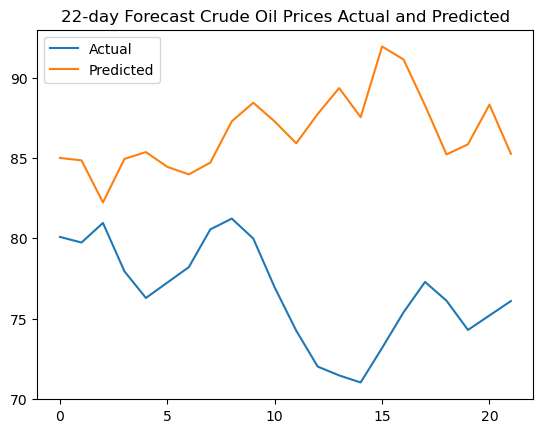

In [ ]:
# Plot the actual vs predicted values
plt.plot(Outofdata, label="Actual")
plt.plot(y_pred_new_last_22_days, label="Predicted")
plt.legend()
plt.title('22-day Forecast Crude Oil Prices Actual and Predicted')

# Add legend and show the plot
plt.legend()


In [ ]:
# Convert y_pred to a DataFrame
y_pred_new_last_22_days = pd.DataFrame(y_pred_new_last_22_days, columns=['Predicted Price'])

# Save the DataFrame to an Excel file
y_pred_new_last_22_days.to_excel('22 days prediction.xlsx', index=False)

In [ ]:
y_pred_new_last_22_days

array([84.99463296, 84.84588896, 82.22775434, 84.93514181, 85.36152998,
       84.43931236, 83.97322042, 84.70705478, 87.27521297, 88.43521779,
       87.2652951 , 85.90690851, 87.73129834, 89.34730788, 87.5329972 ,
       91.93457613, 91.12175353, 88.26667835, 85.21278598, 85.8474093 ,
       88.31625162, 85.25244944])

In [ ]:
# Get the corresponding last 5 days of y_pred_new
y_pred_new_last_5_days = y_pred_new[-5:]
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate mean absolute percentage error (MAPE)
mape_new = mean_absolute_percentage_error(OutofSample[:5], y_pred_new_last_5_days)
print("Mean Absolute Percentage Error:", mape_new)

# Calculate mean absolute error (MAE)
mae_new = mean_absolute_error(OutofSample[:5], y_pred_new_last_5_days)
print("Mean Absolute Error:", mae_new)

# Calculate root mean squared error (RMSE)
rmse_new = mean_squared_error(OutofSample[:5], y_pred_new_last_5_days, squared=False)
print("Root Mean Squared Error:", rmse_new)

Mean Absolute Percentage Error: 0.09645076289615276
Mean Absolute Error: 7.5831149377822955
Root Mean Squared Error: 7.864333525309251
